Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [1]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional
from tensorflow.keras.optimizers import Adam
import keras as k
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report
!pip install tensorflow-addons
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
from tensorflow_addons.text import crf_log_likelihood, crf_decode
!pip install transformers

BACKUP_FOLDER_ID = '1EwDUGjrtg8AiUhBFAImg5vEUXxYEqQcS'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name'].replace("_CWR","")

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['incidence'])
print(tag2idx['B-Disease'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.8 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=78b9413bab8df4b4b65d81f66234af862e43834178d5096e91617f553067856e
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 27.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 28.8 MB/s 
     |████████████████████████████████| 7.6 MB 58.7 MB/s 
     |████████████████████████████████| 163 kB 60.5 MB/s 
[3730, 412, 16252, 1313, 9773, 15979, 2554, 15325, 11324, 

In [2]:
from transformers import pipeline, AutoTokenizer
from future.utils import iteritems

tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    unmasker = pipeline('fill-mask', model='allenai/scibert_scivocab_uncased')
    
    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))

    found_subset = False

    while not found_subset:
      random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
      base_labels = [labels[i] for i in random_idxs]
      found_subset = all([tag2idx["O"] in labels for labels in base_labels])

    base_sequences = [dataset[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
      sequence_str = [idx2word[word] for word in sequence]

      # check max number of tokens bert support and truncate sentence before augmentation
      # augmented sentence will be shorter than original sentence if higher than bert limit
      encoding = tokenizer(sequence_str,
                             is_split_into_words=True, 
                             return_offsets_mapping=True, 
                             truncation=True, 
                             max_length=512)
      
      max_n_of_tokens = len([mapping for mapping in encoding["offset_mapping"] if mapping[0] == 0 and mapping[1] != 0])

      truncated_sequence_str = sequence_str[:max_n_of_tokens]
      truncated_labels = base_labels[k][:max_n_of_tokens]

      # print(len(sequence_str),len(truncated_sequence_str),len(base_labels[k]),len(truncated_labels))

      replaceable_indices = [i for i,label in enumerate(truncated_labels) if label == tag2idx["O"]]
      replace_percent = round(random.uniform(0.1, 1), 1)
      replace_qty = max(math.floor(replace_percent*len(replaceable_indices)), 1)
      replace_indices = random.sample(replaceable_indices, k=replace_qty)
      replace_indices.sort()

      masked_text_list = ["[MASK]" if i in replace_indices else word for i,word in enumerate(truncated_sequence_str)]
      new_mask_sent = ' '.join(masked_text_list)
      augmented_text_list = unmasker(new_mask_sent)

      augmented_sentence = truncated_sequence_str.copy()
      if len(replace_indices) == 1:
        augmented_text_list = [augmented_text_list]

      for i,index in enumerate(replace_indices):
        available_words = [word["token_str"] for word in augmented_text_list[i] if word["token_str"] != truncated_sequence_str[index]]
        new_word = random.choice(available_words)
        if new_word != "[UNK]":
          augmented_sentence[index] = new_word

      # print("Original text->",len(sequence_str),sequence_str)
      # print("Augmented text->",len(sequence_str),augmented_sentence)

      new_sequences.append(augmented_sentence)
      new_labels.append(truncated_labels)

    all_words = list(set([word for seq in new_sequences for word in seq]))
    updated_word2idx = word2idx.copy()
    updated_idx2word = idx2word.copy()
    for word in all_words:
      try:
        updated_word2idx[word]
      except:
        updated_word2idx[word] = len(updated_word2idx)
    updated_idx2word = {i: w for w, i in iteritems(updated_word2idx)}

    updated_n_words = len(updated_idx2word.items())

    new_sequences = [[updated_word2idx[word] for word in seq] for seq in new_sequences]

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train, updated_n_words, updated_word2idx

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/228k [00:00<?, ?B/s]

In [3]:
# Graph plot function 
plt.style.use('ggplot')

def plot_history(history):
    # accuracy = history.history['crf_viterbi_accuracy']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [4]:
# This function converts predicted values to labels from idx2tag
# This is to improve the interpretability of the results
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out

In [5]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -oq glove.6B.zip

--2022-10-28 07:21:41--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-10-28 07:21:41--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-10-28 07:21:42--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [6]:
path_to_glove_file = "./glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [7]:
embedding_dim = 100

def generate_embedding_matrix(n_words, word2idx):
  num_tokens = n_words + 1
  hits = 0
  misses = 0

  # Prepare embedding matrix
  embedding_matrix = np.zeros((num_tokens, embedding_dim))
  for word, i in word2idx.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          # Words not found in embedding index will be all-zeros.
          # This includes the representation for "padding" and "OOV"
          embedding_matrix[i] = embedding_vector
          hits += 1
      else:
          misses += 1
  print("Converted %d words (%d misses)" % (hits, misses))
  return embedding_matrix

In [8]:
class CRF(L.Layer):
    def __init__(self,
                 output_dim,
                 sparse_target=True,
                 **kwargs):
        """    
        Args:
            output_dim (int): the number of labels to tag each temporal input.
            sparse_target (bool): whether the the ground-truth label represented in one-hot.
        Input shape:
            (batch_size, sentence length, output_dim)
        Output shape:
            (batch_size, sentence length, output_dim)
        """
        super(CRF, self).__init__(**kwargs)
        self.output_dim = int(output_dim) 
        self.sparse_target = sparse_target
        self.input_spec = L.InputSpec(min_ndim=3)
        self.supports_masking = False
        self.sequence_lengths = None
        self.transitions = None

    def build(self, input_shape):
        assert len(input_shape) == 3
        f_shape = tf.TensorShape(input_shape)
        input_spec = L.InputSpec(min_ndim=3, axes={-1: f_shape[-1]})

        if f_shape[-1] is None:
            raise ValueError('The last dimension of the inputs to `CRF` '
                             'should be defined. Found `None`.')
        if f_shape[-1] != self.output_dim:
            raise ValueError('The last dimension of the input shape must be equal to output'
                             ' shape. Use a linear layer if needed.')
        self.input_spec = input_spec
        self.transitions = self.add_weight(name='transitions',
                                           shape=[self.output_dim, self.output_dim],
                                           initializer='glorot_uniform',
                                           trainable=True)
        self.built = True

    def compute_mask(self, inputs, mask=None):
        # Just pass the received mask from previous layer, to the next layer or
        # manipulate it if this layer changes the shape of the input
        return mask

    def call(self, inputs, sequence_lengths=None, training=None, **kwargs):
        sequences = tf.convert_to_tensor(inputs, dtype=self.dtype)
        if sequence_lengths is not None:
            assert len(sequence_lengths.shape) == 2
            assert tf.convert_to_tensor(sequence_lengths).dtype == 'int32'
            seq_len_shape = tf.convert_to_tensor(sequence_lengths).get_shape().as_list()
            assert seq_len_shape[1] == 1
            self.sequence_lengths = K.flatten(sequence_lengths)
        else:
            self.sequence_lengths = tf.ones(tf.shape(inputs)[0], dtype=tf.int32) * (
                tf.shape(inputs)[1]
            )

        viterbi_sequence, _ = crf_decode(sequences,
                                         self.transitions,
                                         self.sequence_lengths)
        output = K.one_hot(viterbi_sequence, self.output_dim)
        return K.in_train_phase(sequences, output)

    @property
    def loss(self):
        def crf_loss(y_true, y_pred):
            y_pred = tf.convert_to_tensor(y_pred, dtype=self.dtype)
            log_likelihood, self.transitions = crf_log_likelihood(
                y_pred,
                tf.cast(K.argmax(y_true), dtype=tf.int32) if self.sparse_target else y_true,
                self.sequence_lengths,
                transition_params=self.transitions,
            )
            return tf.reduce_mean(-log_likelihood)
        return crf_loss

    @property
    def accuracy(self):
        def viterbi_accuracy(y_true, y_pred):
            # -1e10 to avoid zero at sum(mask)
            mask = K.cast(
                K.all(K.greater(y_pred, -1e10), axis=2), K.floatx())
            shape = tf.shape(y_pred)
            sequence_lengths = tf.ones(shape[0], dtype=tf.int32) * (shape[1])
            y_pred, _ = crf_decode(y_pred, self.transitions, sequence_lengths)
            if self.sparse_target:
                y_true = K.argmax(y_true, 2)
            y_pred = K.cast(y_pred, 'int32')
            y_true = K.cast(y_true, 'int32')
            corrects = K.cast(K.equal(y_true, y_pred), K.floatx())
            return K.sum(corrects * mask) / K.sum(mask)
        return viterbi_accuracy

    def compute_output_shape(self, input_shape):
        tf.TensorShape(input_shape).assert_has_rank(3)
        return input_shape[:2] + (self.output_dim,)

    def get_config(self):
        config = {
            'output_dim': self.output_dim,
            'sparse_target': self.sparse_target,
            'supports_masking': self.supports_masking,
            'transitions': K.eval(self.transitions)
        }
        base_config = super(CRF, self).get_config()
        return dict(base_config, **config)

In [9]:
# Model creation function
def create_model(maxlen, n_words, embedding_matrix):
    model = Sequential()
    model.add(Embedding(input_dim=n_words+1, output_dim=embedding_dim, 
                    input_length=maxlen, weights=[embedding_matrix], mask_zero=True))
    model.add(Bidirectional(LSTM(units=embedding_dim, return_sequences=True, 
                              dropout=0.1)))
    model.add(TimeDistributed(Dense(n_tags)))
    crf = CRF(n_tags, sparse_target=True)
    model.add(crf)
    adam = Adam(learning_rate=0.005)
    model.compile(optimizer=adam, loss=crf.loss, metrics=[crf.accuracy, 'accuracy'])
    model.summary()
    return model

In [10]:
# Model training function
def train(model, X_train_df, y_train_df, X_dev_df, y_dev_df):
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
  callbacks_list = [early_stopping]

  batch_size = round(0.05*len(X_train_df))
  if batch_size > 16:
    batch_size = 16
  if batch_size < 10:
    batch_size = 10

  history = model.fit(X_train_df, np.array(y_train_df),
                      batch_size=batch_size,
                      epochs=500,
                      validation_data=(X_dev_df,  np.array(y_dev_df)),
                      validation_batch_size=512,
                      verbose=1,
                      callbacks=callbacks_list)
  plot_history(history)

In [11]:
# Model testing function
def test(model, X_test_df, y_test_df):
  test_pred = model.predict(X_test_df, verbose=1)   

  pred_labels = pred2label(test_pred)
  test_labels = pred2label(y_test_df)
  
  print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
  report = classification_report(y_pred=pred_labels, y_true=test_labels, output_dict=True)
  df = pd.DataFrame(report).transpose()
  print("Classification Report:")
  print(df.to_csv())

In [12]:
def create_train_and_validate_model(augmented_percentage):
  augmented_X_train, augmented_y_train, updated_n_words, updated_word2idx = generate_sentences(X_train, y_train, augmented_percentage)

  # Preparing data for training. 
  # X = observations vector. For text sequence labeling, observations are the index of the words in the sentences
  # y = labels vector. For text sequence labeling, labels are the index of tags in the sentences
  # The BI-LSTM layer expects all texts/sentences to be of the same length. 
  # So, we need to pad shorter sentences
  # We select the padding size to be the length of the longest sentence.

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_dev = max([len(s) for s in y_dev])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_y_test = max([len(s) for s in y_test])

  maxlen = max([maxlen_X_train, maxlen_y_train, maxlen_X_dev, maxlen_y_dev, maxlen_X_test, maxlen_y_test])

  augmented_X_train = pad_sequences(maxlen=maxlen, sequences=augmented_X_train, padding="post",value=updated_word2idx["PAD"])
  new_X_dev = pad_sequences(maxlen=maxlen, sequences=X_dev, padding="post",value=updated_word2idx["PAD"])
  new_X_test = pad_sequences(maxlen=maxlen, sequences=X_test, padding="post",value=updated_word2idx["PAD"])

  augmented_y_train = pad_sequences(maxlen=maxlen, sequences=augmented_y_train, padding="post", value=tag2idx["O"])
  new_y_dev = pad_sequences(maxlen=maxlen, sequences=y_dev, padding="post", value=tag2idx["O"])
  new_y_test = pad_sequences(maxlen=maxlen, sequences=y_test, padding="post", value=tag2idx["O"])

  # Converts vector y (integers) to binary matrix.
  # Each y is a one-hot vector where only the position of the tag gests "1"
  augmented_y_train = [to_categorical(i, num_classes=n_tags) for i in augmented_y_train]
  new_y_dev = [to_categorical(i, num_classes=n_tags) for i in new_y_dev]
  new_y_test = [to_categorical(i, num_classes=n_tags) for i in new_y_test]

  embedding_matrix = generate_embedding_matrix(updated_n_words, updated_word2idx)

  model = None
  model = create_model(maxlen, updated_n_words, embedding_matrix)

  train(model, augmented_X_train, augmented_y_train, new_X_dev, new_y_dev)

  test(model, new_X_test, new_y_test)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Converted 10886 words (7674 misses)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 651, 100)          1856100   
                                                                 
 bidirectional (Bidirectiona  (None, 651, 200)         160800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 651, 5)           1005      
 ibuted)                                                         
                                                                 
 crf (CRF)                   (None, 651, 5)            25        
                                                                 
Total params: 2,017,930
Trainable params: 2,017,930
Non-trainable para

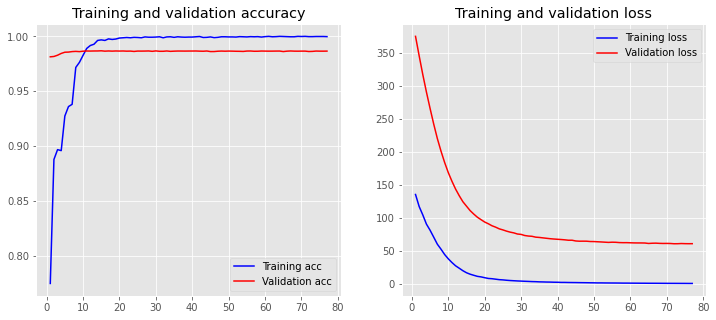

32/32 [==============================] - 10s 205ms/step
F1-score: 51.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.588780487804878,0.478968253968254,0.5282275711159738,5040.0
Disease,0.5030120481927711,0.489074115791845,0.49594517418617934,4439.0
micro avg,0.5447956273764258,0.48370081232197487,0.5124336406817547,9479.0
macro avg,0.5458962679988246,0.4840211848800495,0.5120863726510766,9479.0
weighted avg,0.5486152695921823,0.48370081232197487,0.5131097781028545,9479.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Converted 10882 words (7665 misses)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 651, 100)          1854800   
                                                                 
 bidirectional_1 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_1 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,016,630
Trainable params: 2,016,630
Non-trainable pa

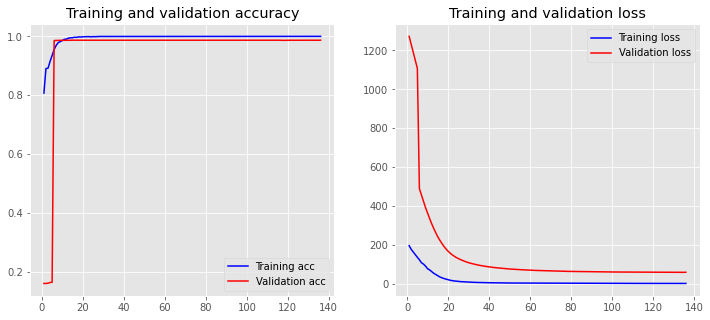

32/32 [==============================] - 10s 209ms/step
F1-score: 50.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.602295918367347,0.46845238095238095,0.5270089285714287,5040.0
Disease,0.5225248154746754,0.46249155215138543,0.49067877629063095,4439.0
micro avg,0.5623646324372531,0.46566093469775294,0.5094644506001847,9479.0
macro avg,0.5624103669210112,0.46547196655188317,0.5088438524310298,9479.0
weighted avg,0.5649392430070169,0.46566093469775294,0.5099955784317028,9479.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Converted 10884 words (7677 misses)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 651, 100)          1856200   
                                                                 
 bidirectional_2 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_2 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,018,030
Trainable params: 2,018,030
Non-trainable pa

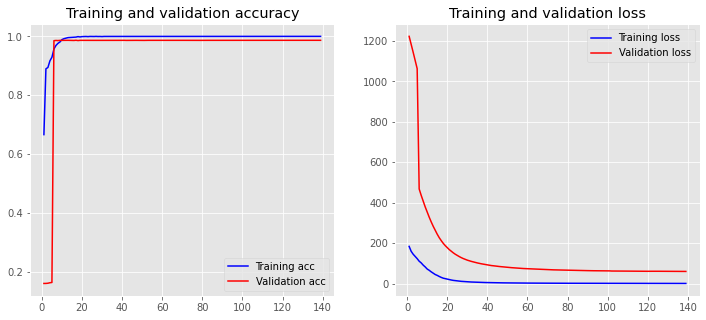

32/32 [==============================] - 10s 209ms/step
F1-score: 49.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.5971354166666667,0.45496031746031745,0.5164414414414414,5040.0
Disease,0.5012171372930867,0.4638432079297139,0.4818064818064818,4439.0
micro avg,0.5475591343734273,0.4591201603544678,0.49945486888162044,9479.0
macro avg,0.5491762769798767,0.45940176269501565,0.4991239616239616,9479.0
weighted avg,0.5522170453047803,0.4591201603544678,0.5002219472100261,9479.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Converted 10885 words (7676 misses)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 651, 100)          1856200   
                                                                 
 bidirectional_3 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_3 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,018,030
Trainable params: 2,018,030
Non-trainable pa

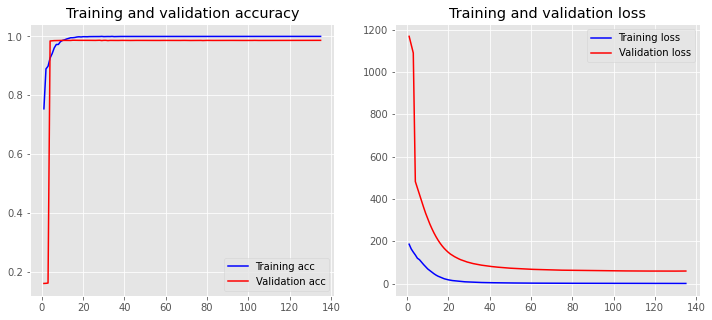

32/32 [==============================] - 10s 206ms/step
F1-score: 49.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6157635467980296,0.44642857142857145,0.5175983436853002,5040.0
Disease,0.5041446872645065,0.4521288578508673,0.4767220902612827,4439.0
micro avg,0.5575638506876228,0.4490980061187889,0.4974874371859296,9479.0
macro avg,0.5599541170312681,0.44927871463971936,0.4971602169732915,9479.0
weighted avg,0.5634926197520006,0.4490980061187889,0.4984560619098794,9479.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Converted 10880 words (7663 misses)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 651, 100)          1854400   
                                                                 
 bidirectional_4 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_4 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,016,230
Trainable params: 2,016,230
Non-trainable pa

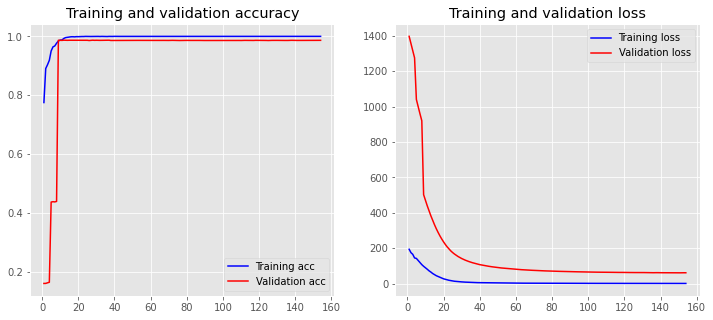

32/32 [==============================] - 10s 219ms/step
F1-score: 51.0%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.5330690590444398,0.5069444444444444,0.519678633174006,5040.0
Disease,0.500794551645857,0.49695877449876097,0.49886928991406604,4439.0
micro avg,0.5176125244618396,0.5022681717480747,0.5098249183487712,9479.0
macro avg,0.5169318053451484,0.5019516094716027,0.509273961544036,9479.0
weighted avg,0.5179549606857194,0.5022681717480747,0.5099336521917428,9479.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Converted 10889 words (7676 misses)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 651, 100)          1856600   
                                                                 
 bidirectional_5 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_5 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_5 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,018,430
Trainable params: 2,018,430
Non-trainable pa

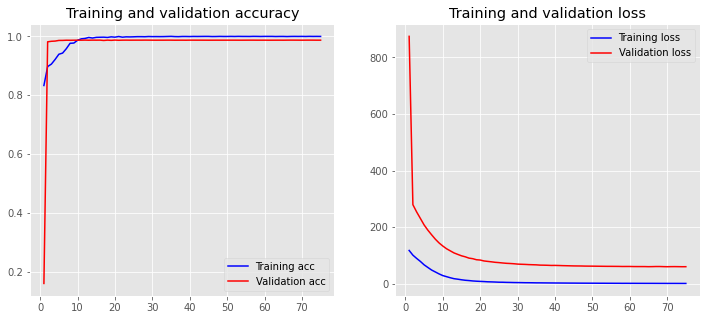

32/32 [==============================] - 10s 214ms/step
F1-score: 52.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.626084800396727,0.5009920634920635,0.5565964950953378,5040.0
Disease,0.5213235294117647,0.4791619734174364,0.49935438431740814,4439.0
micro avg,0.5734007149020092,0.49076906846713786,0.5288767621646203,9479.0
macro avg,0.5737041649042458,0.49007701845474994,0.527975439706373,9479.0
weighted avg,0.5770252707098141,0.49076906846713786,0.5297901094277326,9479.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Converted 10890 words (7686 misses)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 651, 100)          1857700   
                                                                 
 bidirectional_6 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_6 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_6 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,019,530
Trainable params: 2,019,530
Non-trainable pa

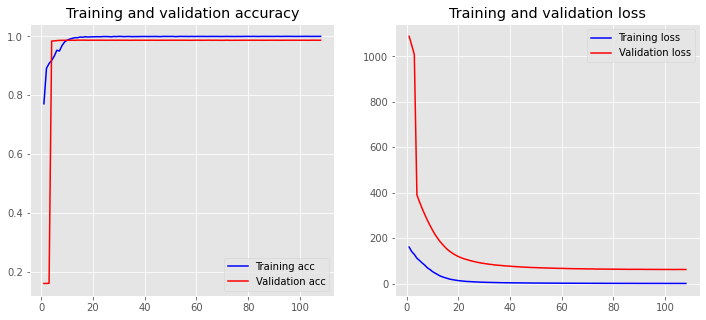

32/32 [==============================] - 10s 216ms/step
F1-score: 50.4%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6249310535024821,0.4496031746031746,0.5229633048696054,5040.0
Disease,0.5142568761039616,0.4591124127055643,0.48512258985955725,4439.0
micro avg,0.5671366451442877,0.45405633505644055,0.5043355987813453,9479.0
macro avg,0.5695939648032219,0.45435779365436946,0.5040429473645813,9479.0
weighted avg,0.5731025195356044,0.45405633505644055,0.5052425607057058,9479.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Converted 10887 words (7669 misses)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 651, 100)          1855700   
                                                                 
 bidirectional_7 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_7 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_7 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,017,530
Trainable params: 2,017,530
Non-trainable pa

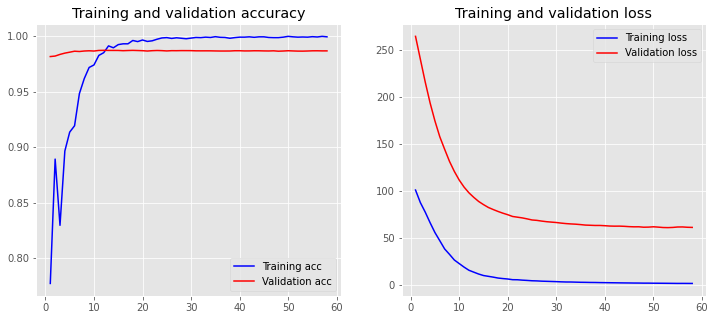

32/32 [==============================] - 10s 217ms/step
F1-score: 51.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.5588042766746673,0.5081349206349206,0.5322664449755794,5040.0
Disease,0.5007956353716754,0.49628294660959676,0.4985290789771441,4439.0
micro avg,0.5303941215764864,0.5025846608292014,0.5161150533557228,9479.0
macro avg,0.5297999560231713,0.5022089336222587,0.5153977619763618,9479.0
weighted avg,0.5316389260317745,0.5025846608292014,0.5164672923574705,9479.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Converted 10883 words (7678 misses)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 651, 100)          1856200   
                                                                 
 bidirectional_8 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_8 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_8 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,018,030
Trainable params: 2,018,030
Non-trainable pa

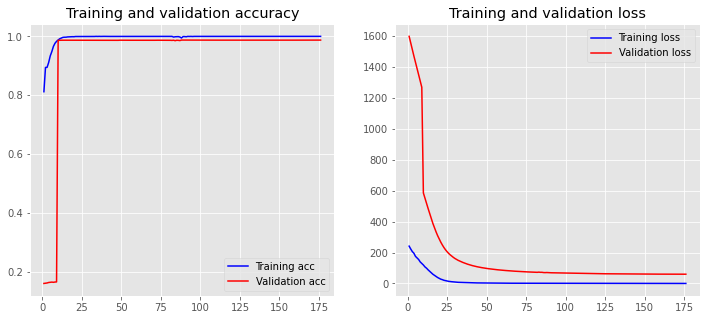

32/32 [==============================] - 10s 208ms/step
F1-score: 52.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6801655335501035,0.45654761904761904,0.5463611539831413,5040.0
Disease,0.5352357320099256,0.48592025230907865,0.5093871767623096,4439.0
micro avg,0.6013759611493322,0.4703027745542779,0.5278238219275396,9479.0
macro avg,0.6077006327800145,0.4712339356783488,0.5278741653727255,9479.0
weighted avg,0.6122951475350333,0.4703027745542779,0.5290463016903603,9479.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Converted 10878 words (7666 misses)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 651, 100)          1854500   
                                                                 
 bidirectional_9 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_9 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_9 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,016,330
Trainable params: 2,016,330
Non-trainable pa

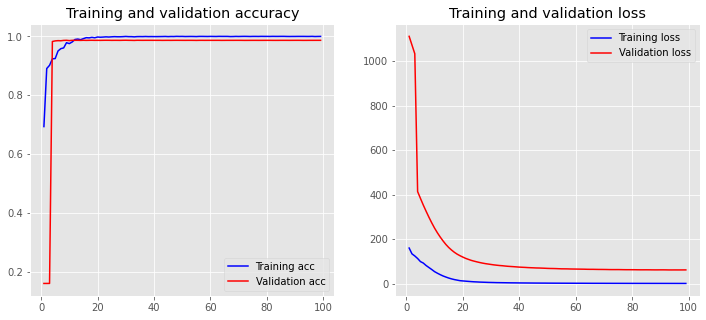

32/32 [==============================] - 10s 213ms/step
F1-score: 49.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6428571428571429,0.45,0.5294117647058824,5040.0
Disease,0.48304263565891475,0.44920027033115567,0.46550717870899966,4439.0
micro avg,0.5566875653082549,0.44962548792066676,0.49746133644587104,9479.0
macro avg,0.5629498892580288,0.44960013516557784,0.497459471707441,9479.0
weighted avg,0.5680162738358396,0.44962548792066676,0.4994853529282516,9479.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Converted 10890 words (7679 misses)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 651, 100)          1857000   
                                                                 
 bidirectional_10 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_10 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_10 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,018,830
Trainable params: 2,018,830
Non-trainable p

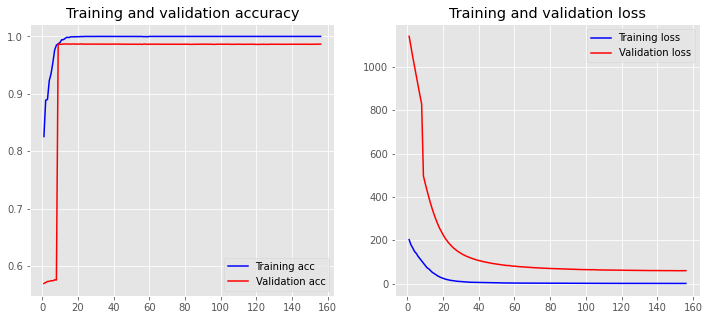

32/32 [==============================] - 10s 209ms/step
F1-score: 50.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.5586398334489937,0.4791666666666667,0.5158603011855174,5040.0
Disease,0.5012065637065637,0.46789817526469923,0.4839799603868111,4439.0
micro avg,0.5305302940829101,0.47388965080704715,0.500612949960994,9479.0
macro avg,0.5299231985777787,0.47353242096568293,0.49992013078616426,9479.0
weighted avg,0.5317439283549282,0.47388965080704715,0.5009307903926641,9479.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Converted 10884 words (7667 misses)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 651, 100)          1855200   
                                                                 
 bidirectional_11 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_11 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_11 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,017,030
Trainable params: 2,017,030
Non-trainable p

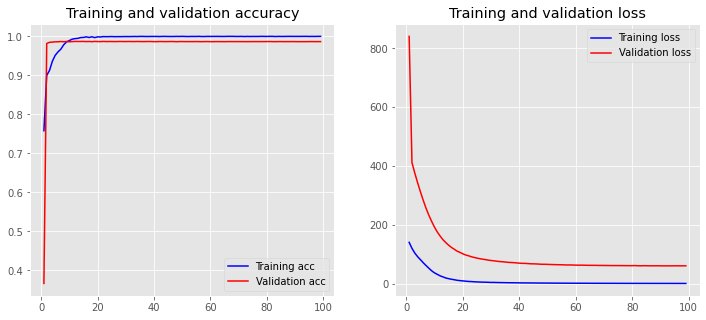

32/32 [==============================] - 10s 210ms/step
F1-score: 49.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.5813443740867024,0.4736111111111111,0.5219768204679641,5040.0
Disease,0.4925373134328358,0.44604640684838925,0.4681404421326398,4439.0
micro avg,0.5374107802116662,0.4607026057601013,0.4961090599261574,9479.0
macro avg,0.5369408437597691,0.4598287589797502,0.4950586313003019,9479.0
weighted avg,0.539756174672997,0.4607026057601013,0.4967653336623406,9479.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Converted 10886 words (7675 misses)
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 651, 100)          1856200   
                                                                 
 bidirectional_12 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_12 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_12 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,018,030
Trainable params: 2,018,030
Non-trainable p

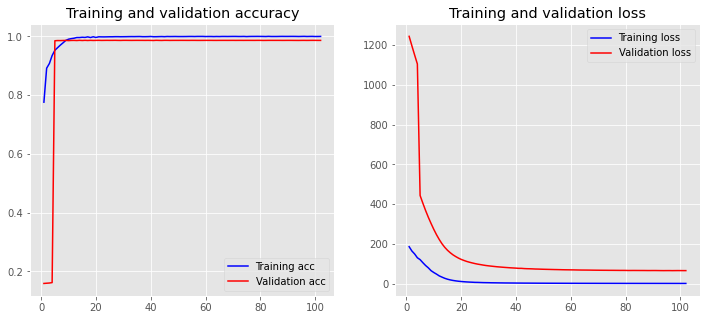

32/32 [==============================] - 10s 215ms/step
F1-score: 49.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.5721689556880021,0.4380952380952381,0.4962355320822564,5040.0
Disease,0.5107151456778233,0.4778103176391079,0.49371508379888274,4439.0
micro avg,0.5403145282076884,0.45669374406582974,0.49499742724829915,9479.0
macro avg,0.5414420506829127,0.45795277786717303,0.49497530794056954,9479.0
weighted avg,0.5433902382457421,0.45669374406582974,0.49505521032575295,9479.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Converted 10889 words (7669 misses)
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 651, 100)          1855900   
                                                                 
 bidirectional_13 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_13 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_13 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,017,730
Trainable params: 2,017,730
Non-trainable p

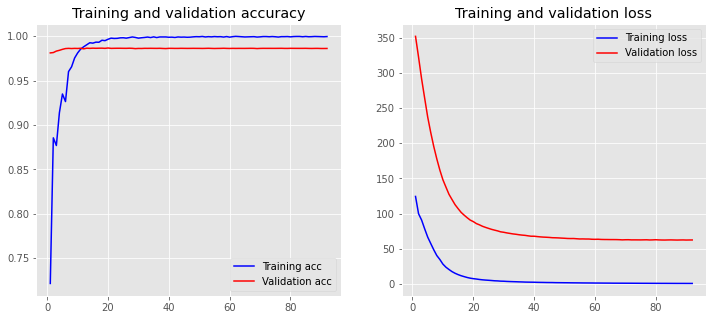

32/32 [==============================] - 10s 215ms/step
F1-score: 50.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6327887011908059,0.45337301587301587,0.5282626285978499,5040.0
Disease,0.5031701749936597,0.44694751070060823,0.4733953710331663,4439.0
micro avg,0.5651310563939634,0.4503639624432957,0.5012622556214407,9479.0
macro avg,0.5679794380922327,0.450160263286812,0.5008289998155081,9479.0
weighted avg,0.5720885600589215,0.4503639624432957,0.5025683827565555,9479.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Converted 10900 words (7688 misses)
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 651, 100)          1858900   
                                                                 
 bidirectional_14 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_14 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_14 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,020,730
Trainable params: 2,020,730
Non-trainable p

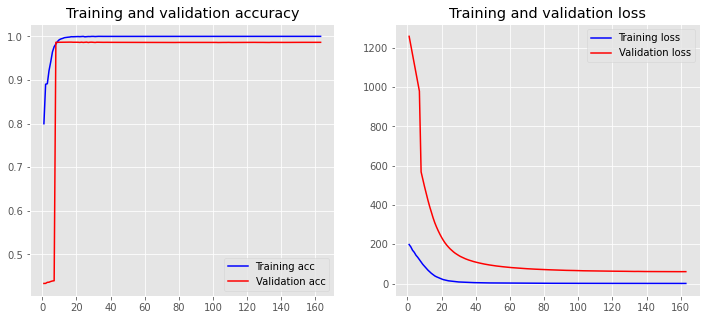

32/32 [==============================] - 10s 213ms/step
F1-score: 50.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.5696382123433436,0.4779761904761905,0.519797173373611,5040.0
Disease,0.49384761003312827,0.4701509348952467,0.4817080207732256,4439.0
micro avg,0.5317563571850976,0.47431163624854944,0.50139400022304,9479.0
macro avg,0.5317429111882359,0.4740635626857186,0.5007525970734183,9479.0
weighted avg,0.534145598812903,0.47431163624854944,0.5019600862976419,9479.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Converted 10895 words (7687 misses)
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 651, 100)          1858300   
                                                                 
 bidirectional_15 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_15 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_15 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,020,130
Trainable params: 2,020,130
Non-trainable p

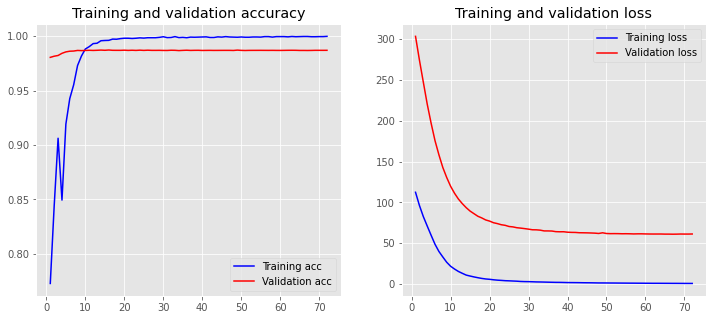

32/32 [==============================] - 10s 218ms/step
F1-score: 51.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6286815304156345,0.4531746031746032,0.5266920327453015,5040.0
Disease,0.5215889464594128,0.47623338589772474,0.4978803579839849,4439.0
micro avg,0.5722092115534738,0.4639729929317439,0.512438100786484,9479.0
macro avg,0.5751352384375237,0.46470399453616396,0.5122861953646431,9479.0
weighted avg,0.5785302507256178,0.4639729929317439,0.5131995731751481,9479.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Converted 10885 words (7679 misses)
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 651, 100)          1856500   
                                                                 
 bidirectional_16 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_16 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_16 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,018,330
Trainable params: 2,018,330
Non-trainable p

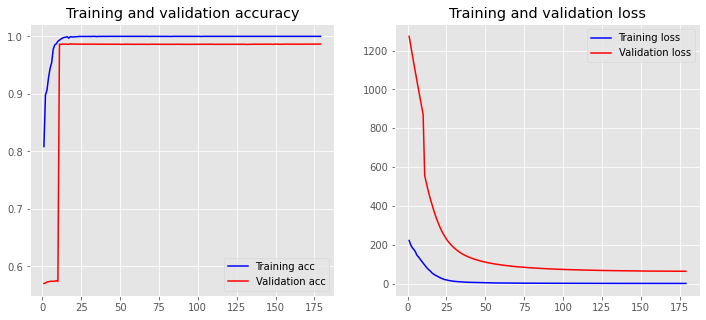

32/32 [==============================] - 10s 219ms/step
F1-score: 49.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.567079207920792,0.45456349206349206,0.504625550660793,5040.0
Disease,0.5122900949136043,0.474205902230232,0.4925128685072532,4439.0
micro avg,0.5394526935820346,0.46376200021099273,0.4987519854776492,9479.0
macro avg,0.5396846514171982,0.46438469714686204,0.49856920958402307,9479.0
weighted avg,0.5414215570463426,0.46376200021099273,0.4989532016704393,9479.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Converted 10888 words (7696 misses)
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 651, 100)          1858500   
                                                                 
 bidirectional_17 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_17 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_17 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,020,330
Trainable params: 2,020,330
Non-trainable p

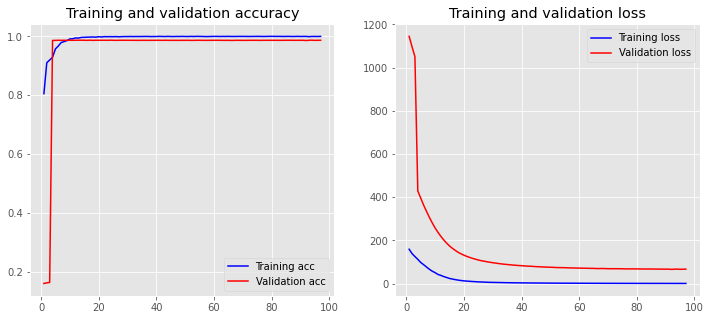

32/32 [==============================] - 10s 214ms/step
F1-score: 51.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.5486906710310966,0.5321428571428571,0.540290088638195,5040.0
Disease,0.4606110995635003,0.4992115341293084,0.4791351351351351,4439.0
micro avg,0.5050005155170636,0.5167211731195274,0.5107936176869329,9479.0
macro avg,0.5046508852972984,0.5156771956360828,0.5097126118866651,9479.0
weighted avg,0.5074431535983864,0.5167211731195274,0.5116513252032248,9479.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Converted 10896 words (7683 misses)
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 651, 100)          1858000   
                                                                 
 bidirectional_18 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_18 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_18 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,019,830
Trainable params: 2,019,830
Non-trainable p

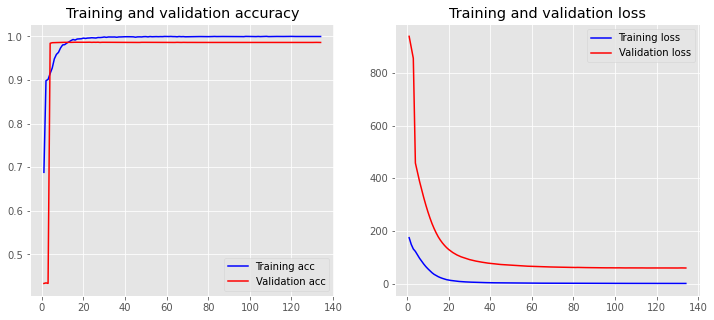

32/32 [==============================] - 10s 220ms/step
F1-score: 49.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.5812163202463433,0.4494047619047619,0.5068815038603558,5040.0
Disease,0.5036792692210099,0.447172786663663,0.4737470167064439,4439.0
micro avg,0.5422301607552947,0.44835953159615993,0.4908471444245539,9479.0
macro avg,0.5424477947336765,0.44828877428421243,0.49031426028339986,9479.0
weighted avg,0.5449058476752435,0.44835953159615993,0.4913646784065933,9479.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Converted 10888 words (7677 misses)
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 651, 100)          1856600   
                                                                 
 bidirectional_19 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_19 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_19 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,018,430
Trainable params: 2,018,430
Non-trainable p

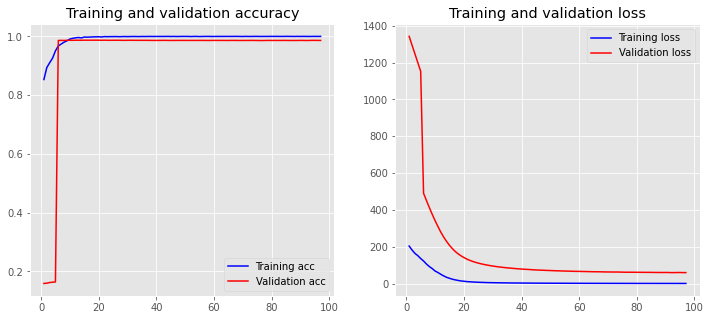

32/32 [==============================] - 10s 219ms/step
F1-score: 50.4%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.5086139389193423,0.5154761904761904,0.5120220733149389,5040.0
Disease,0.5020881670533642,0.48749718405046183,0.4946851068693565,4439.0
micro avg,0.5056275217668295,0.5023736681084503,0.5039953431761656,9479.0
macro avg,0.5053510529863532,0.5014866872633261,0.5033535900921478,9479.0
weighted avg,0.5055579307630941,0.5023736681084503,0.5039032006435664,9479.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Converted 10884 words (7680 misses)
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 651, 100)          1856500   
                                                                 
 bidirectional_20 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_20 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_20 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,018,330
Trainable params: 2,018,330
Non-trainable p

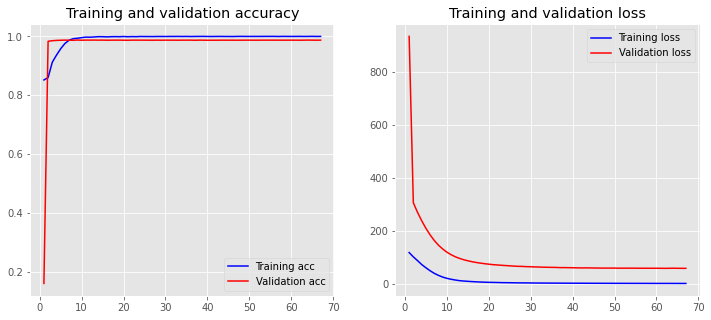

32/32 [==============================] - 10s 216ms/step
F1-score: 52.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6065169094050852,0.4875,0.5405345946540535,5040.0
Disease,0.5341584158415842,0.48614552827213336,0.5090222903644297,4439.0
micro avg,0.5703868495859598,0.4868657031332419,0.5253272623790552,9479.0
macro avg,0.5703376626233347,0.4868227641360667,0.5247784425092417,9479.0
weighted avg,0.5726315467161538,0.4868657031332419,0.5257774347488272,9479.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Converted 10900 words (7696 misses)
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 651, 100)          1859700   
                                                                 
 bidirectional_21 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_21 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_21 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,021,530
Trainable params: 2,021,530
Non-trainable p

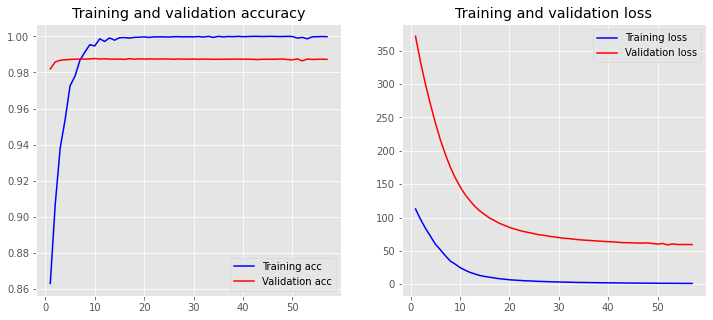

32/32 [==============================] - 10s 218ms/step
F1-score: 53.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.5963241806908769,0.5343253968253968,0.5636249476768522,5040.0
Disease,0.4702324702324702,0.5604865960801982,0.5114080164439877,4439.0
micro avg,0.5282961150198837,0.5465766431058129,0.5372809291714197,9479.0
macro avg,0.5332783254616735,0.5474059964527975,0.5375164820604199,9479.0
weighted avg,0.5372756415280046,0.5465766431058129,0.539171845267032,9479.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Converted 10903 words (7694 misses)
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 651, 100)          1859800   
                                                                 
 bidirectional_22 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_22 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_22 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,021,630
Trainable params: 2,021,630
Non-trainable p

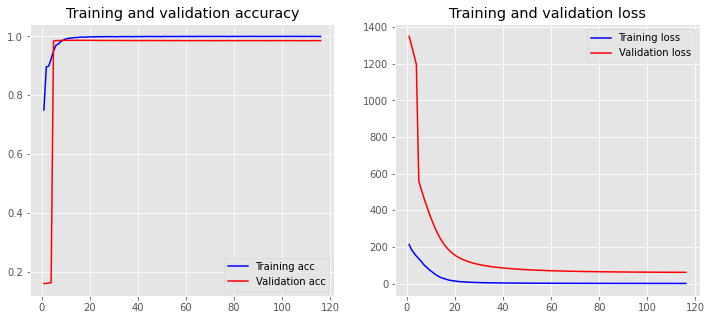

32/32 [==============================] - 10s 212ms/step
F1-score: 48.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.5158544371142796,0.48095238095238096,0.4977923811479618,5040.0
Disease,0.4769515867500579,0.4638432079297139,0.47030607583371403,4439.0
micro avg,0.49722715173025733,0.47294018356366707,0.48477967018113005,9479.0
macro avg,0.49640301193216874,0.47239779444104746,0.4840492284908379,9479.0
weighted avg,0.49763629672322773,0.47294018356366707,0.48492058989467074,9479.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Converted 10894 words (7679 misses)
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 651, 100)          1857400   
                                                                 
 bidirectional_23 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_23 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_23 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,019,230
Trainable params: 2,019,230
Non-trainable p

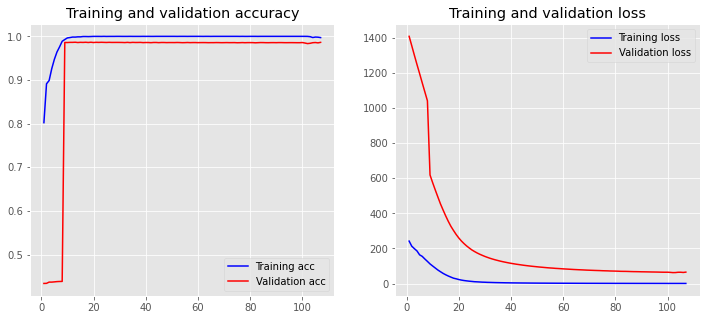

32/32 [==============================] - 10s 215ms/step
F1-score: 48.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.3929171513506527,0.6031746031746031,0.47585505204664624,5040.0
Disease,0.47921177999133824,0.49853570624014415,0.4886827867947444,4439.0
micro avg,0.42517199514366655,0.5541723810528537,0.48117614729321245,9479.0
macro avg,0.43606446567099544,0.5508551547073737,0.48226891942069533,9479.0
weighted avg,0.43332878301390865,0.5541723810528537,0.4818622589826952,9479.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Converted 10901 words (7676 misses)
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 651, 100)          1857800   
                                                                 
 bidirectional_24 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_24 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_24 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,019,630
Trainable params: 2,019,630
Non-trainable p

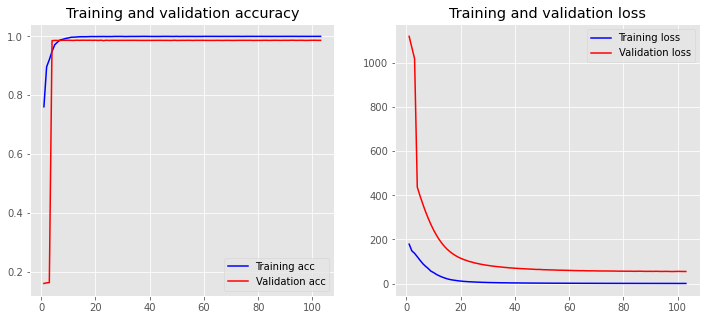

32/32 [==============================] - 10s 221ms/step
F1-score: 50.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.5881907645722937,0.4625,0.5178273908697101,5040.0
Disease,0.5252422233554309,0.46406848389276867,0.492764023442172,4439.0
micro avg,0.5568801521876982,0.4632345184091149,0.5057590416954618,9479.0
macro avg,0.5567164939638622,0.46328424194638435,0.5052957071559411,9479.0
weighted avg,0.5587120669816561,0.4632345184091149,0.5060902574156705,9479.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Converted 10889 words (7680 misses)
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 651, 100)          1857000   
                                                                 
 bidirectional_25 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_25 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_25 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,018,830
Trainable params: 2,018,830
Non-trainable p

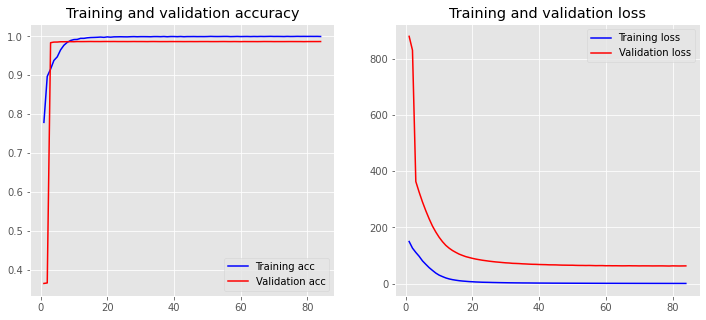

32/32 [==============================] - 10s 208ms/step
F1-score: 50.4%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.593936252915263,0.45476190476190476,0.5151140577592987,5040.0
Disease,0.5096571704490584,0.4755575580085605,0.4920172474070621,4439.0
micro avg,0.5503062117235346,0.4645004747336217,0.5037757437070939,9479.0
macro avg,0.5517967116821607,0.4651597313852326,0.5035656525831804,9479.0
weighted avg,0.5544684981871818,0.4645004747336217,0.5042978597264284,9479.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Converted 10900 words (7679 misses)
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 651, 100)          1858000   
                                                                 
 bidirectional_26 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_26 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_26 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,019,830
Trainable params: 2,019,830
Non-trainable p

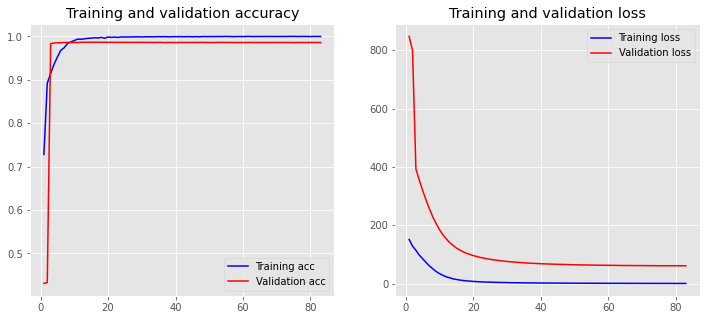

32/32 [==============================] - 10s 214ms/step
F1-score: 48.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.5621805792163543,0.4583333333333333,0.504973221117062,5040.0
Disease,0.46854146806482366,0.4428925433656229,0.45535610885929356,4439.0
micro avg,0.5148705599036725,0.45110243696592467,0.4808816914080072,9479.0
macro avg,0.515361023640589,0.45061293834947813,0.4801646649881778,9479.0
weighted avg,0.5183295385578836,0.45110243696592467,0.4817376096272177,9479.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Converted 10892 words (7694 misses)
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, 651, 100)          1858700   
                                                                 
 bidirectional_27 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_27 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_27 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,020,530
Trainable params: 2,020,530
Non-trainable p

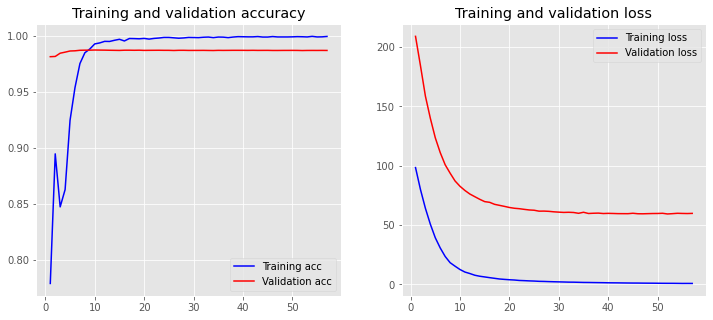

32/32 [==============================] - 10s 214ms/step
F1-score: 52.0%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6627607887967991,0.4601190476190476,0.5431549361751961,5040.0
Disease,0.5178396871945259,0.47735976571299843,0.4967764623139139,4439.0
micro avg,0.5846397049137136,0.4681928473467665,0.5199765670767428,9479.0
macro avg,0.5903002379956626,0.468739406666023,0.5199656992445549,9479.0
weighted avg,0.5948944769482402,0.4681928473467665,0.5214359736822927,9479.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Converted 10892 words (7681 misses)
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, 651, 100)          1857400   
                                                                 
 bidirectional_28 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_28 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_28 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,019,230
Trainable params: 2,019,230
Non-trainable p

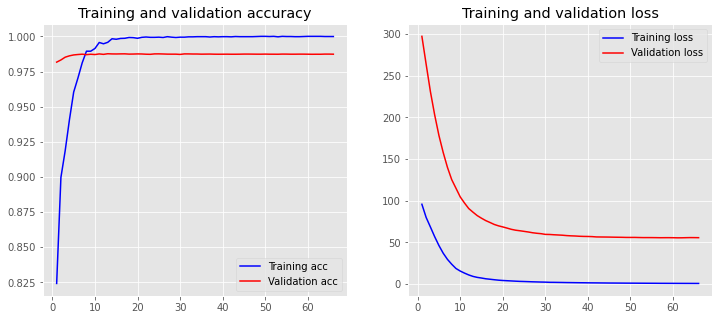

32/32 [==============================] - 10s 209ms/step
F1-score: 53.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6295920952622245,0.4930555555555556,0.5530210303772115,5040.0
Disease,0.5571683218742042,0.49290380716377563,0.5230695672961989,4439.0
micro avg,0.5934721869443739,0.4929844920350248,0.5385812251483894,9479.0
macro avg,0.5933802085682143,0.49297968135966563,0.5380452988367053,9479.0
weighted avg,0.5956761621395932,0.4929844920350248,0.5389948098247678,9479.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Converted 10913 words (7700 misses)
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (None, 651, 100)          1861400   
                                                                 
 bidirectional_29 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_29 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_29 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,023,230
Trainable params: 2,023,230
Non-trainable p

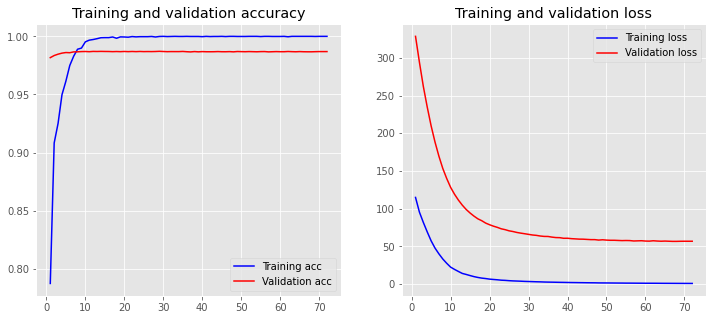

32/32 [==============================] - 10s 212ms/step
F1-score: 50.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.5822631451417495,0.4767857142857143,0.5242718446601942,5040.0
Disease,0.5025380710659898,0.4683487271908087,0.4848414179104477,4439.0
micro avg,0.542352371732817,0.47283468720329147,0.5052133235642224,9479.0
macro avg,0.5424006081038697,0.4725672207382615,0.5045566312853209,9479.0
weighted avg,0.544928025000142,0.47283468720329147,0.5058066411216221,9479.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Converted 10911 words (7701 misses)
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_30 (Embedding)    (None, 651, 100)          1861300   
                                                                 
 bidirectional_30 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_30 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_30 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,023,130
Trainable params: 2,023,130
Non-trainable

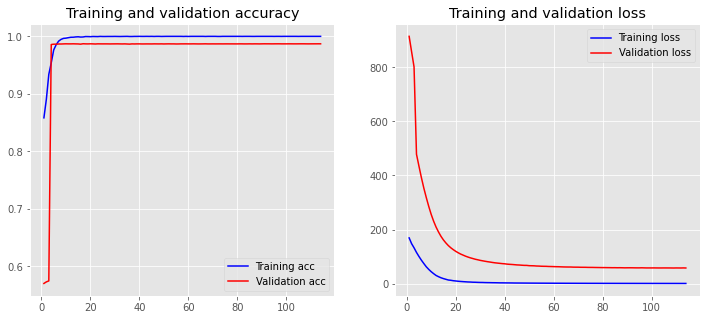

32/32 [==============================] - 10s 217ms/step
F1-score: 51.3%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6332002281802624,0.44047619047619047,0.5195413058740932,5040.0
Disease,0.5344048216976394,0.4793872493804911,0.5054031587697423,4439.0
micro avg,0.5806623931623932,0.4586981749129655,0.5125243118995698,9479.0
macro avg,0.5838025249389509,0.4599317199283408,0.5124722323219177,9479.0
weighted avg,0.5869345029585762,0.4586981749129655,0.5129204350020378,9479.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Converted 10905 words (7702 misses)
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 651, 100)          1860800   
                                                                 
 bidirectional_31 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_31 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_31 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,022,630
Trainable params: 2,022,630
Non-trainable

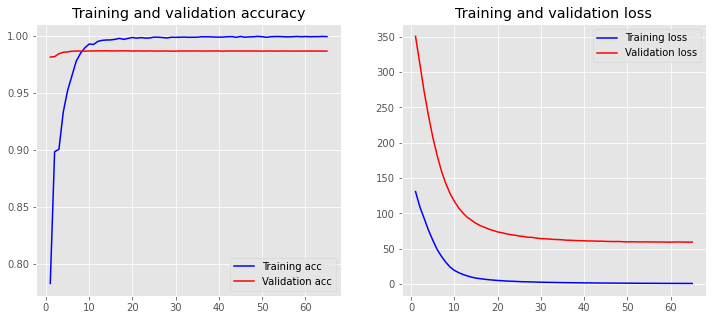

32/32 [==============================] - 10s 215ms/step
F1-score: 50.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6551518761167362,0.4365079365079365,0.5239342700643009,5040.0
Disease,0.5219638242894057,0.45505744537057896,0.4862197617041762,4439.0
micro avg,0.5838406198118429,0.4451946407848929,0.5051774705213384,9479.0
macro avg,0.5885578502030709,0.4457826909392577,0.5050770158842386,9479.0
weighted avg,0.5927801320444164,0.4451946407848929,0.5062726282655253,9479.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Converted 10900 words (7694 misses)
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, 651, 100)          1859500   
                                                                 
 bidirectional_32 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_32 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_32 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,021,330
Trainable params: 2,021,330
Non-trainable

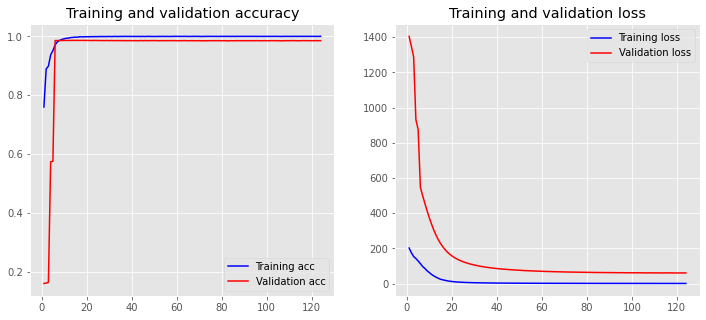

32/32 [==============================] - 10s 212ms/step
F1-score: 47.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.5014767932489451,0.4716269841269841,0.4860940695296523,5040.0
Disease,0.48037602820211517,0.46046406848389276,0.47020933977455714,4439.0
micro avg,0.4914952751528627,0.4663994092203819,0.4786185991122659,9479.0
macro avg,0.4909264107255301,0.46604552630543844,0.4781517046521047,9479.0
weighted avg,0.49159533992656107,0.4663994092203819,0.4786552768951057,9479.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Converted 10891 words (7681 misses)
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_33 (Embedding)    (None, 651, 100)          1857300   
                                                                 
 bidirectional_33 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_33 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_33 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,019,130
Trainable params: 2,019,130
Non-trainable

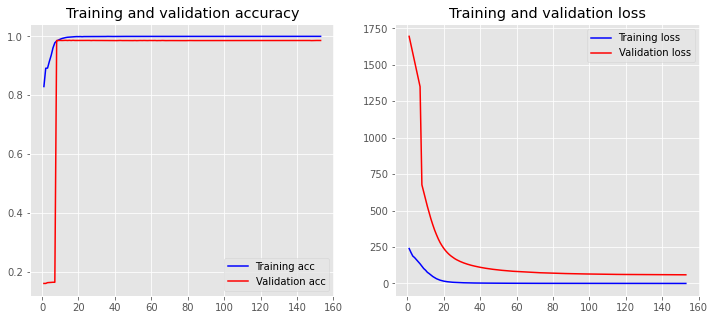

32/32 [==============================] - 10s 206ms/step
F1-score: 49.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.5705143982279104,0.4599206349206349,0.5092826540700868,5040.0
Disease,0.5013437576349865,0.4622662761883307,0.48101265822784806,4439.0
micro avg,0.5358018636586562,0.461019094841228,0.4956053303090446,9479.0
macro avg,0.5359290779314485,0.4610934555544828,0.4951476561489674,9479.0
weighted avg,0.5381219018050822,0.461019094841228,0.49604386184055854,9479.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Converted 10898 words (7698 misses)
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_34 (Embedding)    (None, 651, 100)          1859700   
                                                                 
 bidirectional_34 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_34 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_34 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,021,530
Trainable params: 2,021,530
Non-trainable

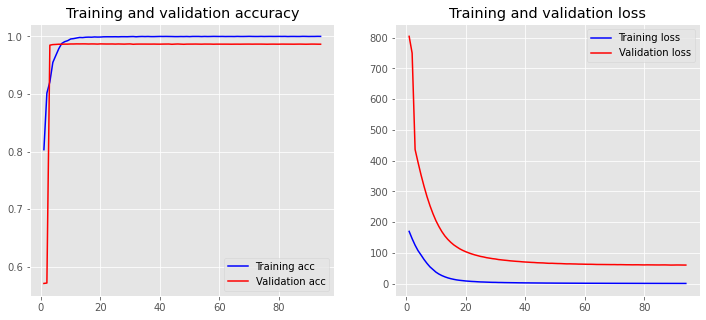

32/32 [==============================] - 10s 211ms/step
F1-score: 49.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6177285318559557,0.44246031746031744,0.515606936416185,5040.0
Disease,0.4974195133939543,0.45595854922279794,0.47578749412317817,4439.0
micro avg,0.5539783826019012,0.4487815170376622,0.49586198857675723,9479.0
macro avg,0.557574022624955,0.4492094333415577,0.4956972152696816,9479.0
weighted avg,0.5613880177771684,0.4487815170376622,0.4969595575430278,9479.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Converted 10882 words (7679 misses)
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_35 (Embedding)    (None, 651, 100)          1856200   
                                                                 
 bidirectional_35 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_35 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_35 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,018,030
Trainable params: 2,018,030
Non-trainable

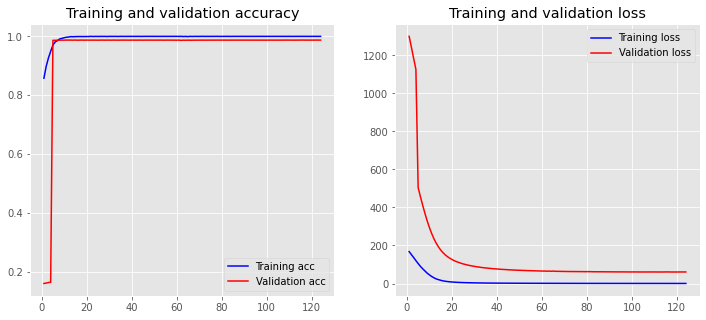

32/32 [==============================] - 10s 211ms/step
F1-score: 52.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6597439544807966,0.4601190476190476,0.5421390999415546,5040.0
Disease,0.5395701643489255,0.48073890515881956,0.5084584226828688,4439.0
micro avg,0.5961178045515395,0.46977529275240004,0.5254587291285622,9479.0
macro avg,0.599657059414861,0.47042897638893355,0.5252987613122118,9479.0
weighted avg,0.6034667676050317,0.46977529275240004,0.5263664945663773,9479.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Converted 10903 words (7695 misses)
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_36 (Embedding)    (None, 651, 100)          1859900   
                                                                 
 bidirectional_36 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_36 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_36 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,021,730
Trainable params: 2,021,730
Non-trainable

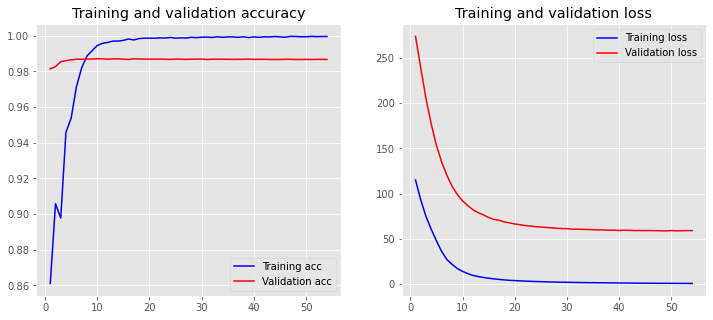

32/32 [==============================] - 10s 212ms/step
F1-score: 50.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.633067838505905,0.4573412698412698,0.5310448105057022,5040.0
Disease,0.51215843569817,0.46023879252083805,0.484812529663028,4439.0
micro avg,0.5698558322411533,0.4586981749129655,0.5082705009059558,9479.0
macro avg,0.5726131371020375,0.45879003118105394,0.507928670084365,9479.0
weighted avg,0.576446165432423,0.4586981749129655,0.5093943099612744,9479.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Converted 10913 words (7701 misses)
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_37 (Embedding)    (None, 651, 100)          1861500   
                                                                 
 bidirectional_37 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_37 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_37 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,023,330
Trainable params: 2,023,330
Non-trainable

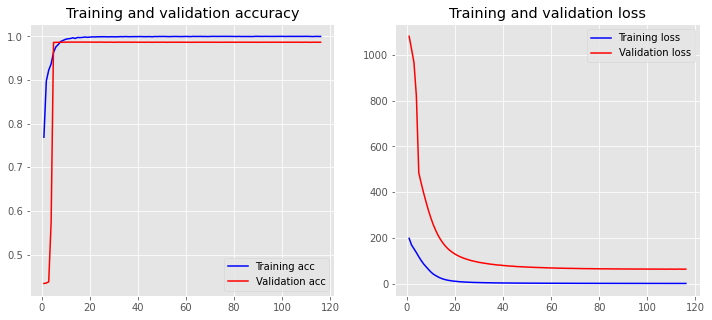

32/32 [==============================] - 10s 216ms/step
F1-score: 49.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6334728033472803,0.4505952380952381,0.5266086956521739,5040.0
Disease,0.5172131147540984,0.4264473980626267,0.4674651191505124,4439.0
micro avg,0.5747412008281574,0.4392868446038612,0.4979669935422148,9479.0
macro avg,0.5753429590506893,0.4385213180789324,0.4970369074013432,9479.0
weighted avg,0.5790285837391851,0.4392868446038612,0.49891185673552924,9479.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Converted 10906 words (7699 misses)
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_38 (Embedding)    (None, 651, 100)          1860600   
                                                                 
 bidirectional_38 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_38 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_38 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,022,430
Trainable params: 2,022,430
Non-trainable

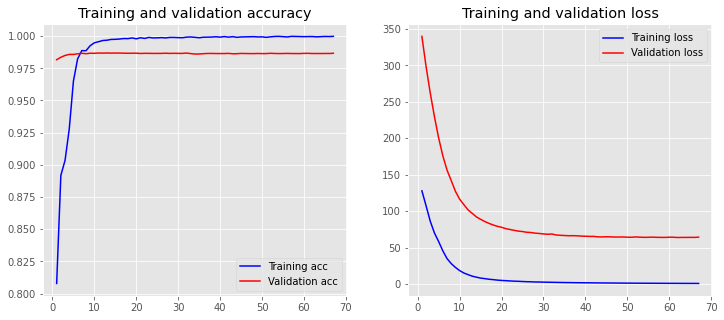

32/32 [==============================] - 10s 206ms/step
F1-score: 50.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.5955770208439247,0.4648809523809524,0.5221751727211945,5040.0
Disease,0.4976958525345622,0.4622662761883307,0.4793272599859846,4439.0
micro avg,0.5454883951843118,0.46365650385061713,0.5012545620437956,9479.0
macro avg,0.5466364366892434,0.46357361428464156,0.5007512163535895,9479.0
weighted avg,0.5497394318445303,0.46365650385061713,0.5021095661559876,9479.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Converted 10902 words (7699 misses)
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_39 (Embedding)    (None, 651, 100)          1860200   
                                                                 
 bidirectional_39 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_39 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_39 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,022,030
Trainable params: 2,022,030
Non-trainable

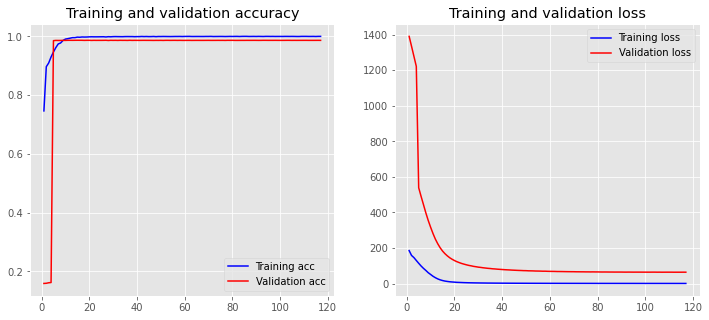

32/32 [==============================] - 10s 213ms/step
F1-score: 49.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6146892655367232,0.43174603174603177,0.5072261072261073,5040.0
Disease,0.5436013590033975,0.4325298490651048,0.48174633044787346,4439.0
micro avg,0.579185520361991,0.4321130920983226,0.4949549876140415,9479.0
macro avg,0.5791453122700603,0.4321379404055683,0.4944862188369904,9479.0
weighted avg,0.5813989166495586,0.4321130920983226,0.4952939699628327,9479.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Converted 10936 words (7728 misses)
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_40 (Embedding)    (None, 651, 100)          1866500   
                                                                 
 bidirectional_40 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_40 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_40 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,028,330
Trainable params: 2,028,330
Non-trainable

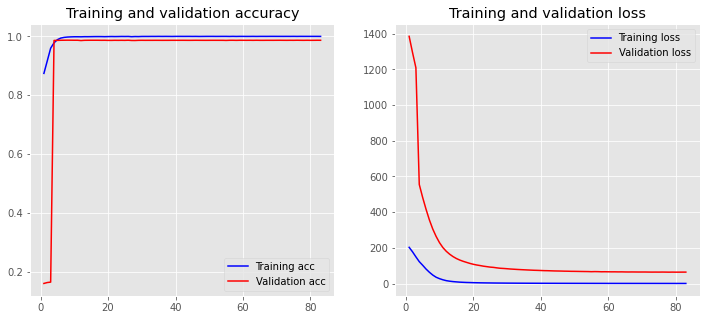

32/32 [==============================] - 10s 214ms/step
F1-score: 49.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6228045720657931,0.44325396825396823,0.5179088906920134,5040.0
Disease,0.5172506017651779,0.43568371254787114,0.4729762778185375,4439.0
micro avg,0.5689325689325689,0.43970883004536343,0.4960428443915501,9479.0
macro avg,0.5700275869154855,0.4394688404009197,0.49544258425527543,9479.0
weighted avg,0.5733738226023021,0.43970883004536343,0.49686702250493037,9479.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Converted 10910 words (7721 misses)
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_41 (Embedding)    (None, 651, 100)          1863200   
                                                                 
 bidirectional_41 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_41 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_41 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,025,030
Trainable params: 2,025,030
Non-trainable

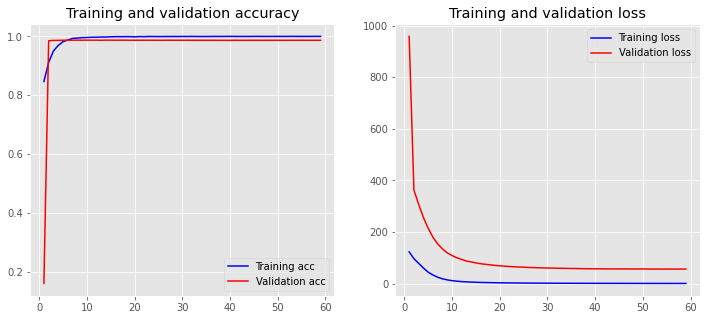

32/32 [==============================] - 10s 213ms/step
F1-score: 50.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6273678258411083,0.44027777777777777,0.5174303369476506,5040.0
Disease,0.5271377368151562,0.4638432079297139,0.4934691431995207,4439.0
micro avg,0.5747682386134623,0.4513134296866758,0.5056139936177757,9479.0
macro avg,0.5772527813281323,0.45206049285374583,0.5054497400735857,9479.0
weighted avg,0.5804302411606355,0.4513134296866758,0.5062093496021554,9479.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Converted 10923 words (7724 misses)
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_42 (Embedding)    (None, 651, 100)          1864800   
                                                                 
 bidirectional_42 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_42 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_42 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,026,630
Trainable params: 2,026,630
Non-trainable

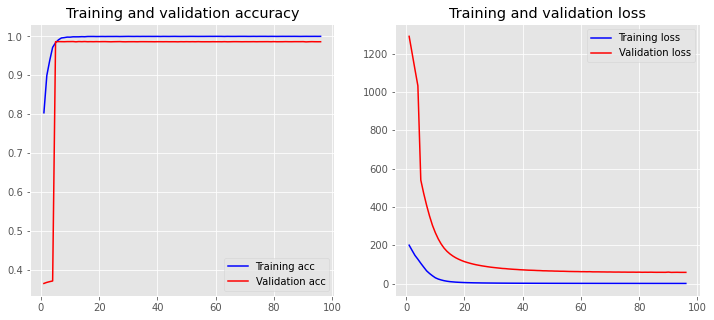

32/32 [==============================] - 10s 208ms/step
F1-score: 48.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.5664961636828645,0.439484126984127,0.4949720670391062,5040.0
Disease,0.5202127659574468,0.44063978373507545,0.4771313574826198,4439.0
micro avg,0.54380704041721,0.4400253191264901,0.4864423581549945,9479.0
macro avg,0.5433544648201556,0.44006195535960124,0.48605171226086297,9479.0
weighted avg,0.5448217251869125,0.4400253191264901,0.4866172923032435,9479.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Converted 10909 words (7711 misses)
Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_43 (Embedding)    (None, 651, 100)          1862100   
                                                                 
 bidirectional_43 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_43 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_43 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,023,930
Trainable params: 2,023,930
Non-trainable

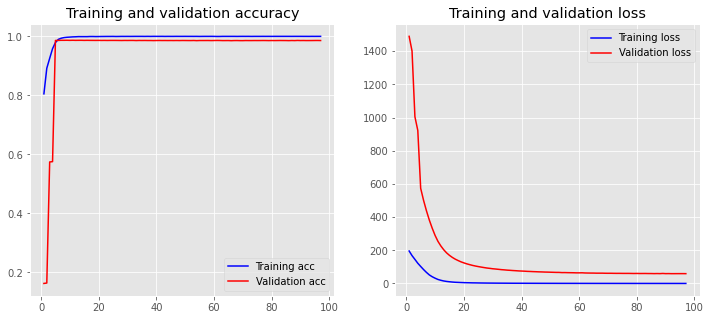

32/32 [==============================] - 10s 213ms/step
F1-score: 49.0%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.5050967339296859,0.48174603174603176,0.49314512034122066,5040.0
Disease,0.5322969713213616,0.4473980626267177,0.4861689106487148,4439.0
micro avg,0.5169828999765753,0.46566093469775294,0.489981683965144,9479.0
macro avg,0.5186968526255238,0.46457204718637474,0.48965701549496776,9479.0
weighted avg,0.5178345600486488,0.46566093469775294,0.48987817289686647,9479.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Converted 10933 words (7735 misses)
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_44 (Embedding)    (None, 651, 100)          1866900   
                                                                 
 bidirectional_44 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_44 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_44 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,028,730
Trainable params: 2,028,730
Non-trainable

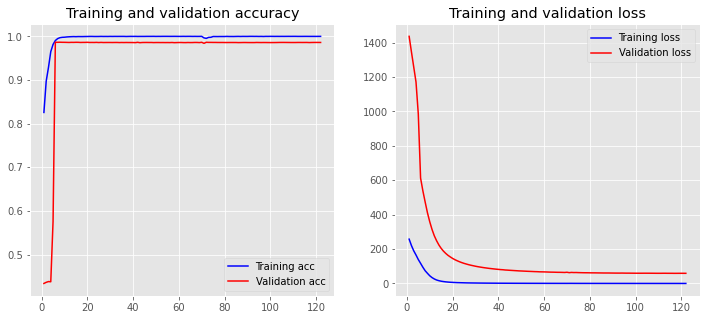

32/32 [==============================] - 10s 208ms/step
F1-score: 49.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.5933774834437087,0.4444444444444444,0.5082246171298922,5040.0
Disease,0.5129492600422833,0.4372606442892543,0.4720904779277636,4439.0
micro avg,0.5531154914671252,0.4410802827302458,0.4907853034393708,9479.0
macro avg,0.553163371742996,0.4408525443668494,0.4901575475288279,9479.0
weighted avg,0.5557130796375132,0.4410802827302458,0.491303059590252,9479.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Converted 10931 words (7720 misses)
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_45 (Embedding)    (None, 651, 100)          1865200   
                                                                 
 bidirectional_45 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_45 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_45 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,027,030
Trainable params: 2,027,030
Non-trainable

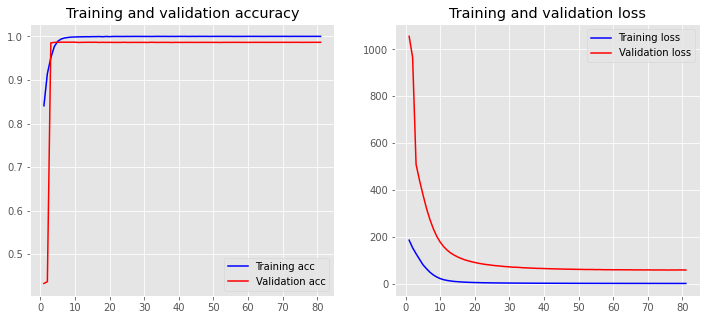

32/32 [==============================] - 10s 211ms/step
F1-score: 48.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6214203894616266,0.4305555555555556,0.5086732301922176,5040.0
Disease,0.5142160844841592,0.4277990538409552,0.4670437776684702,4439.0
micro avg,0.5663187195546276,0.4292646903681823,0.48835813730196825,9479.0
macro avg,0.5678182369728929,0.4291773046982554,0.4878585039303439,9479.0
weighted avg,0.5712167910024033,0.4292646903681823,0.48917822652591153,9479.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Converted 10932 words (7713 misses)
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_46 (Embedding)    (None, 651, 100)          1864600   
                                                                 
 bidirectional_46 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_46 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_46 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,026,430
Trainable params: 2,026,430
Non-trainable

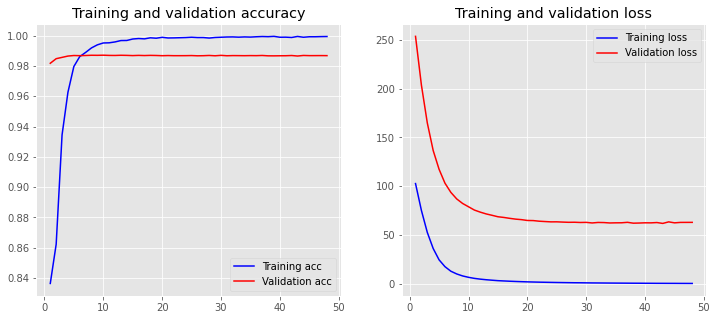

32/32 [==============================] - 10s 210ms/step
F1-score: 50.0%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6136300417246175,0.4376984126984127,0.5109438332368269,5040.0
Disease,0.5055421686746988,0.47262897048884883,0.4885318430550704,4439.0
micro avg,0.555713363460297,0.45405633505644055,0.4997677659080353,9479.0
macro avg,0.5595861051996582,0.4551636915936308,0.49973783814594863,9479.0
weighted avg,0.5630126698005128,0.45405633505644055,0.5004483353555297,9479.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Converted 10915 words (7707 misses)
Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_47 (Embedding)    (None, 651, 100)          1862300   
                                                                 
 bidirectional_47 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_47 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_47 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,024,130
Trainable params: 2,024,130
Non-trainable

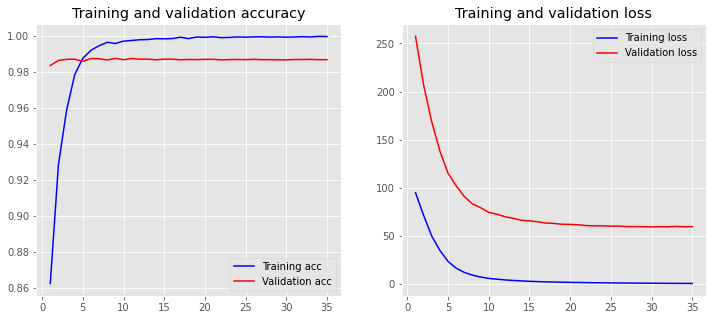

32/32 [==============================] - 10s 212ms/step
F1-score: 51.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.5356991972961554,0.5031746031746032,0.518927767546552,5040.0
Disease,0.5766545657637532,0.46519486370804236,0.5149625935162095,4439.0
micro avg,0.553337342152736,0.485388754087984,0.5171406091941104,9479.0
macro avg,0.5561768815299544,0.48418473344132273,0.5169451805313807,9479.0
weighted avg,0.5548785285154472,0.485388754087984,0.517070883115632,9479.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Converted 10903 words (7704 misses)
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_48 (Embedding)    (None, 651, 100)          1860800   
                                                                 
 bidirectional_48 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_48 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_48 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,022,630
Trainable params: 2,022,630
Non-trainable

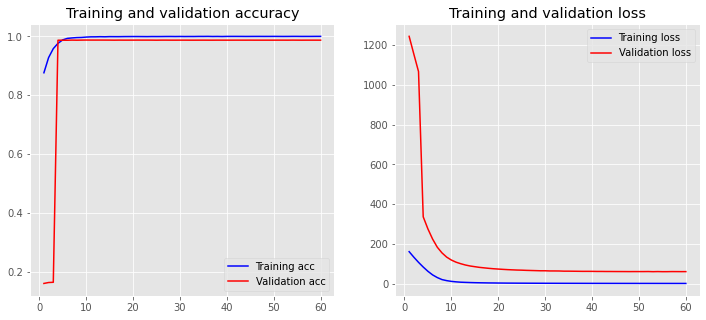

32/32 [==============================] - 10s 206ms/step
F1-score: 51.4%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6257326262908177,0.4448412698412698,0.520004638756813,5040.0
Disease,0.5691920603857982,0.4586618607794548,0.5079840319361278,4439.0
micro avg,0.5974860335195531,0.4513134296866758,0.5142135945669812,9479.0
macro avg,0.5974623433383079,0.4517515653103623,0.5139943353464704,9479.0
weighted avg,0.5992547729252325,0.4513134296866758,0.5143754084923314,9479.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Converted 10927 words (7721 misses)
Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_49 (Embedding)    (None, 651, 100)          1864900   
                                                                 
 bidirectional_49 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_49 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_49 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,026,730
Trainable params: 2,026,730
Non-trainable

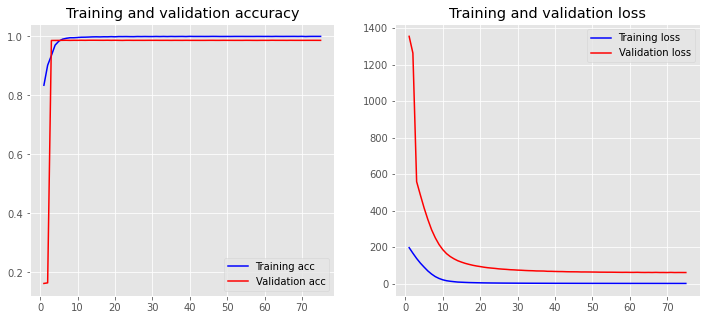

32/32 [==============================] - 10s 214ms/step
F1-score: 48.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.5689836756187467,0.42876984126984125,0.48902466621407553,5040.0
Disease,0.5477671000565291,0.4365848164000901,0.48589695374200825,4439.0
micro avg,0.5587513631406761,0.4324295811794493,0.48754088611358903,9479.0
macro avg,0.5583753878376378,0.4326773288349657,0.48746080997804186,9479.0
weighted avg,0.5590479884238229,0.4324295811794493,0.4875599636438142,9479.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Converted 10969 words (7777 misses)
Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_60 (Embedding)    (None, 651, 100)          1874700   
                                                                 
 bidirectional_60 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_60 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_60 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,036,530
Trainable params: 2,036,530
Non-trainable

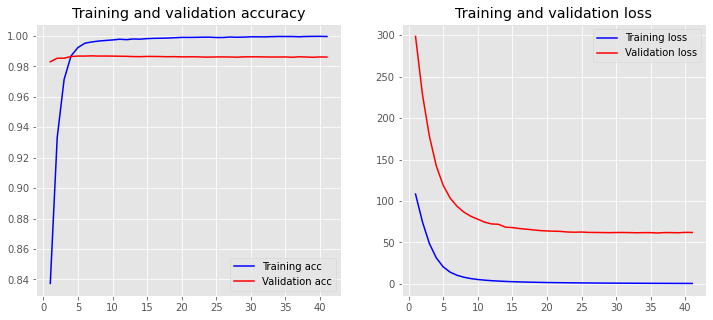

32/32 [==============================] - 10s 217ms/step
F1-score: 48.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.563933626159102,0.458531746031746,0.5057999562267453,5040.0
Disease,0.5219310344827586,0.426222122099572,0.46924603174603174,4439.0
micro avg,0.544218567914023,0.4434012026585083,0.48866410882455524,9479.0
macro avg,0.5429323303209304,0.44237693406565903,0.48752299398638854,9479.0
weighted avg,0.544263882045663,0.4434012026585083,0.4886818139364312,9479.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Converted 10975 words (7756 misses)
Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_61 (Embedding)    (None, 651, 100)          1873200   
                                                                 
 bidirectional_61 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_61 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_61 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,035,030
Trainable params: 2,035,030
Non-trainable

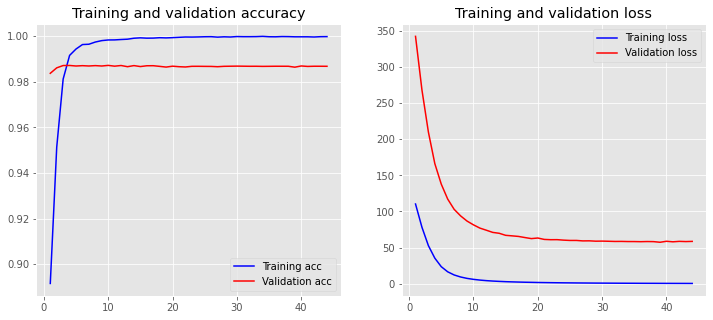

32/32 [==============================] - 10s 213ms/step
F1-score: 50.3%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.5654890651285749,0.46686507936507937,0.5114661449842409,5040.0
Disease,0.5206922498118887,0.4676728993016445,0.4927605032043674,4439.0
micro avg,0.5435689739813451,0.46724338010338645,0.5025245362228399,9479.0
macro avg,0.5430906574702318,0.4672689893333619,0.5021133240943041,9479.0
weighted avg,0.544510790712416,0.46724338010338645,0.502706323920747,9479.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Converted 10945 words (7770 misses)
Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_62 (Embedding)    (None, 651, 100)          1871600   
                                                                 
 bidirectional_62 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_62 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_62 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,033,430
Trainable params: 2,033,430
Non-trainable

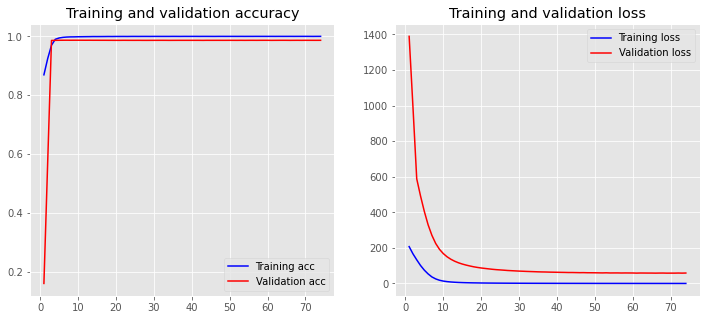

32/32 [==============================] - 10s 210ms/step
F1-score: 49.3%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6506132216571942,0.43154761904761907,0.5189073124179887,5040.0
Disease,0.5205555555555555,0.4221671547645866,0.4662271426794377,4439.0
micro avg,0.5831773008785828,0.42715476316067097,0.4931189867251249,9479.0
macro avg,0.5855843886063749,0.42685738690610286,0.4925672275487132,9479.0
weighted avg,0.5897074320353802,0.42715476316067097,0.4942372761832141,9479.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Converted 10978 words (7778 misses)
Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_63 (Embedding)    (None, 651, 100)          1875700   
                                                                 
 bidirectional_63 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_63 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_63 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,037,530
Trainable params: 2,037,530
Non-trainable

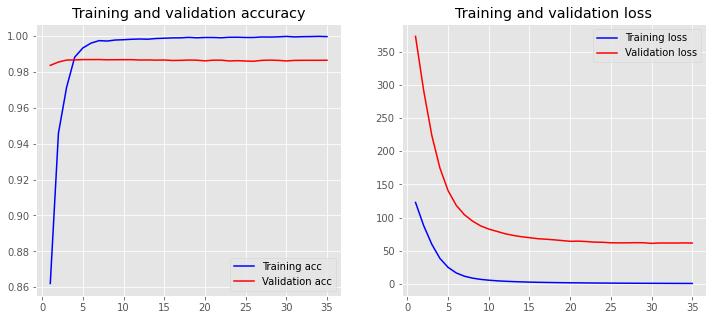

32/32 [==============================] - 10s 215ms/step
F1-score: 48.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.5553080920564217,0.4452380952380952,0.49421869838123555,5040.0
Disease,0.5225671797547613,0.45122775399864834,0.484284332688588,4439.0
micro avg,0.5393700787401575,0.44804304251503324,0.48948308649801187,9479.0
macro avg,0.5389376359055915,0.4482329246183718,0.48925151553491175,9479.0
weighted avg,0.5399755770540933,0.44804304251503324,0.4895664513815876,9479.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Converted 10971 words (7767 misses)
Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_64 (Embedding)    (None, 651, 100)          1873900   
                                                                 
 bidirectional_64 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_64 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_64 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,035,730
Trainable params: 2,035,730
Non-trainable

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Converted 10969 words (7766 misses)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 651, 100)          1873600   
                                                                 
 bidirectional (Bidirectiona  (None, 651, 200)         160800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 651, 5)           1005      
 ibuted)                                                         
                                                                 
 crf (CRF)                   (None, 651, 5)            25        
                                                                 
Total params: 2,035,430
Trainable params: 2,035,430
Non-trainable pa

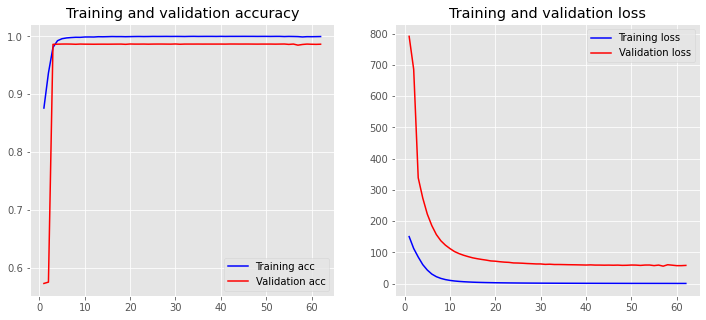

32/32 [==============================] - 10s 211ms/step
F1-score: 49.4%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.41653439153439153,0.6248015873015873,0.49984126984126986,5040.0
Disease,0.5364725095264018,0.4440189231808966,0.4858868482682115,4439.0
micro avg,0.45575930211856863,0.5401413651229032,0.4943755129628736,9479.0
macro avg,0.47650345053039667,0.534410255241242,0.4928640590547407,9479.0
weighted avg,0.47270121353740174,0.5401413651229032,0.49330643733121543,9479.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Converted 10988 words (7773 misses)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 651, 100)          1876200   
                                                                 
 bidirectional_1 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_1 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,038,030
Trainable params: 2,038,030
Non-trainable 

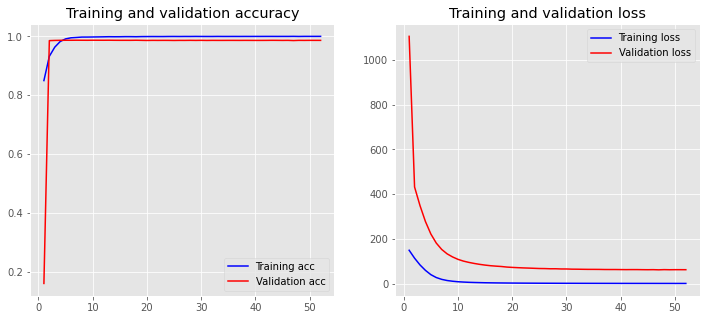

32/32 [==============================] - 10s 213ms/step
F1-score: 49.4%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.5289886660854403,0.48154761904761906,0.5041545492314083,5040.0
Disease,0.5277852348993288,0.4428925433656229,0.4816266536011759,4439.0
micro avg,0.5284494165764465,0.46344551112986604,0.49381744604316546,9479.0
macro avg,0.5283869504923846,0.46222008120662095,0.49289060141629215,9479.0
weighted avg,0.5284251012542187,0.46344551112986604,0.49360477302056316,9479.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Converted 10975 words (7772 misses)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 651, 100)          1874800   
                                                                 
 bidirectional_2 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_2 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,036,630
Trainable params: 2,036,630
Non-trainable 

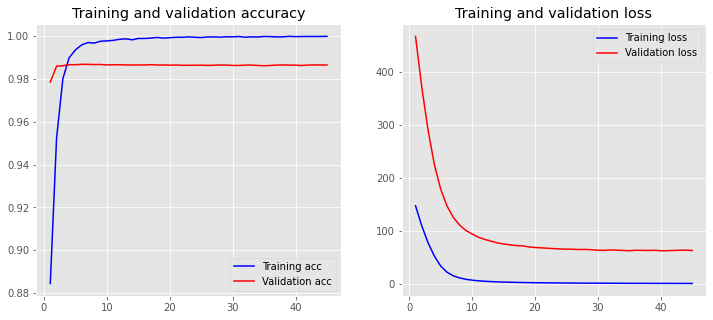

32/32 [==============================] - 10s 219ms/step
F1-score: 47.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.5872501350621285,0.43134920634920637,0.4973690231068406,5040.0
Disease,0.5608650156958493,0.36224374859202524,0.4401861483712018,4439.0
micro avg,0.5757345105799969,0.39898723494039456,0.47133599202392823,9479.0
macro avg,0.5740575753789889,0.3967964774706158,0.4687775857390212,9479.0
weighted avg,0.5748940273643848,0.39898723494039456,0.47059037757972794,9479.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Converted 10955 words (7755 misses)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 651, 100)          1871100   
                                                                 
 bidirectional_3 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_3 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,032,930
Trainable params: 2,032,930
Non-trainable 

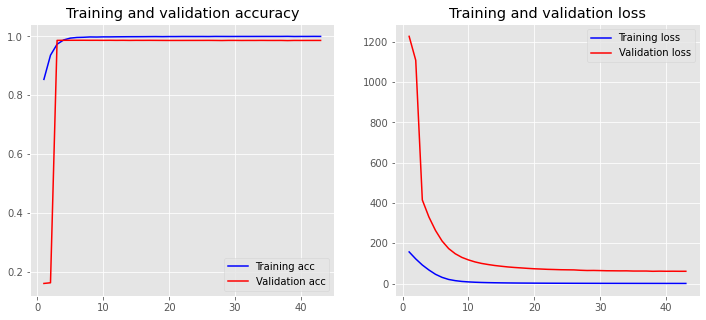

32/32 [==============================] - 10s 211ms/step
F1-score: 47.0%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.5237633365664404,0.42857142857142855,0.47140986468790924,5040.0
Disease,0.5077448149120504,0.43568371254787114,0.4689621726479146,4439.0
micro avg,0.5160721038699105,0.43190209937757146,0.4702504020215943,9479.0
macro avg,0.5157540757392454,0.43212757055964984,0.47018601866791193,9479.0
weighted avg,0.5162618894070525,0.43190209937757146,0.4702636145596746,9479.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Converted 10994 words (7773 misses)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 651, 100)          1876800   
                                                                 
 bidirectional_4 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_4 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,038,630
Trainable params: 2,038,630
Non-trainable 

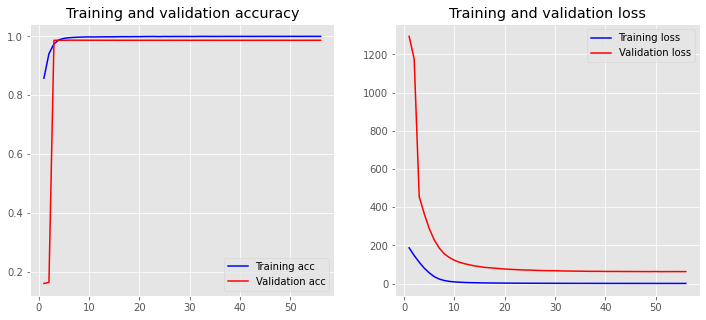

32/32 [==============================] - 10s 217ms/step
F1-score: 48.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6414800995024875,0.4093253968253968,0.49975775193798444,5040.0
Disease,0.5476546160740962,0.4129308402793422,0.47084510660159257,4439.0
micro avg,0.5936309614505562,0.4110138200232092,0.4857249719486348,9479.0
macro avg,0.5945673577882918,0.4111281185523695,0.4853014292697885,9479.0
weighted avg,0.5975417810154499,0.4110138200232092,0.4862180080147601,9479.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Converted 10969 words (7779 misses)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 651, 100)          1874900   
                                                                 
 bidirectional_5 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_5 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_5 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,036,730
Trainable params: 2,036,730
Non-trainable 

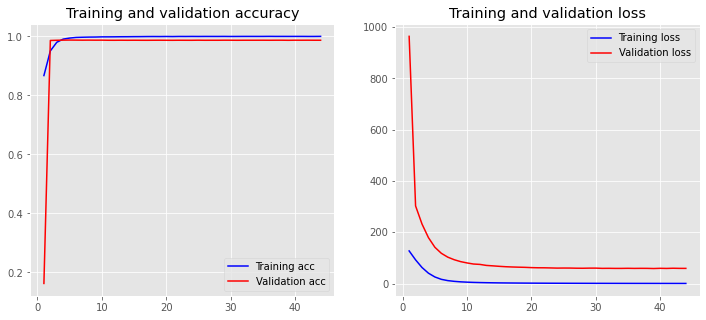

32/32 [==============================] - 10s 215ms/step
F1-score: 50.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.5989261744966443,0.44265873015873014,0.5090701654306902,5040.0
Disease,0.5521970333053456,0.4444694751070061,0.4925112331502746,4439.0
micro avg,0.5760482323924363,0.44350669901888384,0.5011623055373429,9479.0
macro avg,0.575561603900995,0.4435641026328681,0.5007906992904824,9479.0
weighted avg,0.577042995073902,0.44350669901888384,0.5013156448702129,9479.0



In [13]:
number_of_training_models = 6
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)